# Jar Targetting System
## Training Program
Liam Akkerman, Aidan Hunter

In [1]:
# import os
# os._exit(00)

In [2]:
# load libraries

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [3]:
# coords_to_image(y_data_raw, shape=(*x_data.shape[:3], 1))
def coords_to_image(coords, shape=(500,500,1), high_value=0.999):
    '''
    convert a list of tuples of jar coordinates into an image with dots at the centre location.
    TODO the high value must be lower than 1 for Keras.
    '''

    image = np.zeros(shape, dtype='float')
    for i, pt_list in enumerate(coords): # TODO rewrite with better looping
        for pt in pt_list:
            image[i, int(np.floor(pt[0])), int(np.floor(pt[1])), :] = high_value 
    return image

In [4]:
# coords_to_image(y_data_raw, shape=(*x_data.shape[:3], 1))
def coords_to_image_full(coords, shape=(500,500,1), high_value=0.999):
    '''
    convert a list of tuples of jar coordinates into an image with entire circles filled.
    TODO the high value must be lower than 1 for Keras.
    '''

    from skimage.draw import disk

    shape_padded = (shape[0] + 100, shape[1] + 100, 1)

    image = np.zeros(shape, dtype='float')
    for i, pt_list in enumerate(coords): # TODO rewrite with better looping
        for pt in pt_list:
            rr, cc = disk(pt, 35) # draw a circle
            image[i, cc, rr, :] = high_value # write it onto the image
    image_trimmed = image[:shape[0], :shape[1]]
    print(image_trimmed.shape)
    return image

In [5]:
def image_to_coords(image, high_threashold=0.5):
    '''
    convert an image of jar centres into a list of tuples. the image contains a pixel at each coordinate of jar centres.
    '''

    if not image.ndim == 3:
        if image.ndim == 4 and image.shape[0] == 1:
            image = np.reshape(image, image.shape[1:])
        else:
            raise ValueError('misshapped image')
    
    coords = list()
    for x, column in enumerate(image):
        for y, value in enumerate(column): #TODO rewrite with better looping
            if value > high_threashold:
                coords.append((x,y))

    return coords

In [6]:
def overlay_centres(coords, ax):
    '''
    overlays list of coordinates as red circles onto a plt axis obeject (created with subplot)
    '''

    import matplotlib.patches as patches

    for point in coords:
        outline_marker = patches.Circle(point, radius=35, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(outline_marker)
        centre_marker = patches.Circle(point, radius=2, color='r')
        ax.add_patch(centre_marker)

In [7]:
# load the dataset

from glob import glob
import bz2
import pickle

dataset = list()

# loads every archive of the dataset
archive_list = glob('../dataset/*.pkl.bz2')
for archive in archive_list:
    with bz2.BZ2File(archive, mode='r') as f:
        dataset.extend(pickle.load(f))

print('archives contained', len(dataset), 'datapoints')

archives contained 170 datapoints


In [8]:
# Split the data

x_data = np.asarray([a['image']/255.0 for a in dataset if not a['testing']], dtype='float')

y_data_raw = [a['label'] for a in dataset if not a['testing']]
# for row in y_data_raw:
#     if len(row) > 0:
#         print(np.amax(row))
y_data_coord = np.asarray(y_data_raw, dtype='object')
y_data_image = coords_to_image_full(y_data_raw, shape=(*x_data.shape[:3], 1))

print('loaded', len(x_data), 'datapoints')

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_image, test_size=0.2, shuffle=True)

print('training:', len(x_train), 'pts,\t testing:', len(x_test), 'pts')
print('X is shape', x_train.shape, '\tof type', type(x_train))
print('Y is shape', y_train.shape, '\tof type', type(y_train))


# clear the memeroy beacuse this is big
# dataset = None 
# x_data = None
# y_data = None

(170, 500, 500, 1)
loaded 170 datapoints
training: 136 pts,	 testing: 34 pts
X is shape (136, 500, 500, 3) 	of type <class 'numpy.ndarray'>
Y is shape (136, 500, 500, 1) 	of type <class 'numpy.ndarray'>


In [9]:
# x_data = None
# y_data_raw = None
# y_data = None

In [10]:
# visualize all samples
# saves them all to a folder and pngs

# all_samples = list(zip(x_data, y_data_coord))
# for i, sample in enumerate(all_samples):
#     fig, ax = plt.subplots()
#     plt.imshow(sample[0])

#     plt.xlim([0, 500])
#     plt.ylim([0, 500])
#     plt.title('sample ' + str(i))
#     #plt.axis('off')

#     overlay_centres(sample[1], ax)

#     plt.savefig('../samples/sample' + str(i) + '.png', format='png')
#     plt.close()


<class 'tuple'>


(0.0, 500.0)

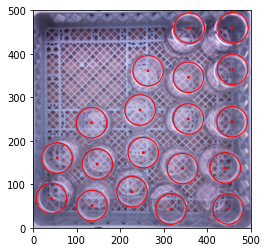

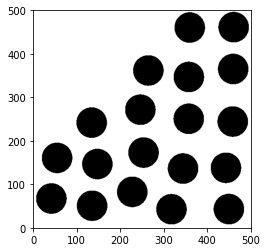

In [11]:
# visualize a sample
from random import choice

rand_image = choice(list(zip(x_data, y_data_coord, y_data_image)))
print(type(rand_image))
while len(rand_image[1]) < 5:    # make sure the chosen one is interesting
    rand_image = choice(list(zip(x_data, y_data_coord, y_data_image)))

fig, ax = plt.subplots()
plt.imshow(rand_image[0])
plt.xlim([0, 500])
plt.ylim([0, 500])
#plt.axis('off')

overlay_centres(rand_image[1], ax)

fig, ax = plt.subplots()
plt.imshow(rand_image[2], cmap='binary')
plt.xlim([0, 500])
plt.ylim([0, 500])

In [14]:
# define the model layers
# TODO currently this is just the 4th CNN from assigment 3

model = keras.Sequential([
    keras.layers.Input(shape=x_data[0].shape),
    keras.layers.Conv2D(filters=8, kernel_size=5, strides=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=3, strides=None, padding="same"),
    keras.layers.Conv2D(filters=16, kernel_size=5, strides=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=3, strides=None, padding="same")
])

# model = keras.Sequential([
#     keras.layers.Input(shape=x_data[0].shape),
#     keras.layers.Conv2D(filters=8, kernel_size=5, activation='relu', padding='same'),
#     keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same'),
#     keras.layers.MaxPooling2D(pool_size=(3, 3), padding="same")
# ])

# l2 = None
# model = keras.Sequential([
#     keras.layers.Conv2D(16,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2),
#     keras.layers.BatchNormalization(momentum=0.99),
#     keras.layers.Conv2D(32,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2),
#     keras.layers.BatchNormalization(momentum=0.99),
#     keras.layers.Conv2D(1,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2)
# ])

In [15]:
# train and evalute the model
print('X is shape', x_train.shape, '\tof type', type(x_train))
print('Y is shape', y_train.shape, '\tof type', type(y_train))

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

hist = model.fit(x=x_train, y=y_train, epochs=5)
loss, acc = model.evaluate(x=x_test, y=y_test)

print('test accuracy:', acc)
print('test loss:', loss)

X is shape (136, 500, 500, 3) 	of type <class 'numpy.ndarray'>
Y is shape (136, 500, 500, 1) 	of type <class 'numpy.ndarray'>
Epoch 1/5


ValueError: in user code:

    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\training.py:758 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:408 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\metrics.py:618 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\metrics.py:3315 sparse_categorical_accuracy
        return math_ops.cast(math_ops.equal(y_true, y_pred), K.floatx())
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\ops\math_ops.py:1679 equal
        return gen_math_ops.equal(x, y, name=name)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:3178 equal
        name=name)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\framework\op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\framework\func_graph.py:592 _create_op_internal
        compute_device)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\framework\ops.py:3536 _create_op_internal
        op_def=op_def)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\framework\ops.py:2016 __init__
        control_input_ops, op_def)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\framework\ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 500 and 7 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](Squeeze, Cast_1)' with input shapes: [?,500,500], [?,7,7].


(1, 500, 500, 3)
(1, 500, 500, 1)
found 0 centres
results: []


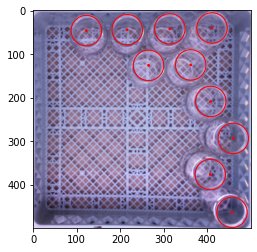

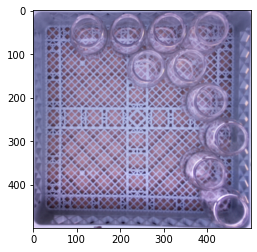

In [47]:
rand_image = choice(list(zip(x_test, y_test)))

rand_input = np.reshape(rand_image[0], (1, *rand_image[0].shape))
rand_output = np.reshape(rand_image[1], (1, *rand_image[1].shape))
print(rand_input.shape)
print(rand_output.shape)

fig, ax = plt.subplots()
plt.imshow(rand_image[0])
overlay_centres(image_to_coords(rand_image[1]), ax)


test_result = model.predict(rand_input)
print('found', np.count_nonzero(test_result), 'centres')
test_coords = image_to_coords(test_result)
print('results:', test_coords)
fig, ax = plt.subplots()
plt.imshow(rand_image[0])
overlay_centres(test_coords, ax)

In [10]:
# convert and save model

from datetime import datetime

# format is YYYYMMDDHHmm
filename = 'model-' + datetime.now().strftime('%Y%m%d%H%M') + '.tflite'
print('writing', filename)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(filename, 'wb') as f:
    f.write(tflite_model)

writing model-202104171245.tflite
INFO:tensorflow:Assets written to: C:\Users\liam\AppData\Local\Temp\tmpwuvumq06\assets
